# Импорт библиотек

In [ ]:
!pip install ultralytics
import os
import json
import time
import numpy as np
import cv2
from ultralytics import YOLO
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Подготовка данных для обучения

In [ ]:
!unzip /content/drive/MyDrive/475_fire_train.zip -d /content
!unzip /content/drive/MyDrive/474_fire_val.zip -d /content

Archive:  /content/drive/MyDrive/475_fire_train.zip
   creating: /content/475_fire_train/
   creating: /content/475_fire_train/annotations/
  inflating: /content/475_fire_train/annotations/instances_default.json  
   creating: /content/475_fire_train/images/
  inflating: /content/475_fire_train/images/00000.jpg  
  inflating: /content/475_fire_train/images/000044.jpg  
  inflating: /content/475_fire_train/images/000047.jpg  
  inflating: /content/475_fire_train/images/000098.jpg  
  inflating: /content/475_fire_train/images/000101.jpg  
  inflating: /content/475_fire_train/images/000107.jpg  
  inflating: /content/475_fire_train/images/000112.jpg  
  inflating: /content/475_fire_train/images/000114.jpg  
  inflating: /content/475_fire_train/images/000116.jpg  
  inflating: /content/475_fire_train/images/000121.jpg  
  inflating: /content/475_fire_train/images/000127.jpg  
  inflating: /content/475_fire_train/images/000130.jpg  
  inflating: /content/475_fire_train/images/000134.jpg  
 

Преобразуем данные в формат, необходимый для подачи в YOLO

In [ ]:
def convert_coco_to_yolo(coco_json_path, output_dir, images_dir):
    with open(coco_json_path) as f:
        data = json.load(f)

    # мапинг для целевых классов
    CLASS_MAP = {
        'fire': 0,
        'smoke': 1
    }

    coco_categories = {c['id']: c['name'] for c in data['categories']}

    valid_ids = [cat_id for cat_id, cat_name in coco_categories.items()
                if cat_name in CLASS_MAP]

    os.makedirs(output_dir, exist_ok=True)

    for img in data['images']:
        img_id = img['id']
        anns = [a for a in data['annotations']
               if a['image_id'] == img_id
               and a['category_id'] in valid_ids]

        filename = os.path.basename(img['file_name'])
        txt_path = os.path.join(output_dir, f"{os.path.splitext(filename)[0]}.txt")

        with open(txt_path, 'w') as f_txt:
            for ann in anns:
                # COCO ID -> YOLO ID (конвертируем)
                coco_class_id = ann['category_id']
                class_name = coco_categories[coco_class_id]
                yolo_class_id = CLASS_MAP[class_name]

                x, y, w, h = ann['bbox']
                img_w = img['width']
                img_h = img['height']

                # -> YOLO формат
                x_center = (x + w/2) / img_w
                y_center = (y + h/2) / img_h
                w_norm = w / img_w
                h_norm = h / img_h

                f_txt.write(f"{yolo_class_id} {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}\n")

train_json = '/content/475_fire_train/annotations/instances_default.json'
val_json = '/content/474_fire_val/annotations/instances_default.json'

convert_coco_to_yolo(train_json, '/content/475_fire_train/labels', '/content/475_fire_train/images')
convert_coco_to_yolo(val_json, '/content/474_fire_val/labels', '/content/474_fire_val/images')

yolo_config = '''
train: /content/475_fire_train/images
val: /content/474_fire_val/images

nc: 2
names: ['fire', 'smoke']
'''

with open('data.yaml', 'w') as f:
    f.write(yolo_config)

print("Конвертация завершена и конфиг создан!")

Конвертация завершена и конфиг создан!


# Обучение YOLOv8m

Обратившись к документации https://docs.ultralytics.com/modes/train/#augmentation-settings-and-hyperparameters я установил значения гиперпараметров. Количество эпох 20, батч размера 16, размер изображения 640. В том числе выполняются аугментации (мозаика, mixup, горизонтальное отражение) для расширения количества примеров тренировочного датасета с целью повысить обобщающую способность модели.

In [ ]:
args = {
    'classes': [0, 1],
    'data': 'data.yaml',
    'model': 'yolov8m.pt',
    'epochs': 20,
    'batch': 16,
    'imgsz': 640,
    'val': True,
    'plots': True,
    'optimizer': 'AdamW',
    'lr0': 0.001,
    'hsv_h': 0.015,
    'hsv_s': 0.7,
    'hsv_v': 0.4,
    'degrees': 15.0,
    'fliplr': 0.5,
    'mosaic': 1.0,
    'mixup': 0.1,
    'copy_paste': 0.1,
    'conf': 0.1,
    'iou': 0.4,
    'device': 0,
    'name': 'smoke_fire_detection'
}

# Запуск обучения
model = YOLO(args['model'])

100%|██████████| 49.7M/49.7M [00:00<00:00, 131MB/s]


In [ ]:
results = model.train(**args)

Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=smoke_fire_detection, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=0.1, iou=0.4, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=[0, 1], retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=Non

100%|██████████| 755k/755k [00:00<00:00, 16.3MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 106MB/s]


AMP: checks passed ✅


train: Scanning /content/475_fire_train/labels... 1142 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1142/1142 [00:00<00:00, 2100.12it/s]

train: New cache created: /content/475_fire_train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/474_fire_val/labels... 308 images, 0 backgrounds, 0 corrupt: 100%|██████████| 308/308 [00:00<00:00, 771.17it/s]

val: New cache created: /content/474_fire_val/labels.cache


Plotting labels to runs/detect/smoke_fire_detection/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/smoke_fire_detection
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      6.37G      1.808      2.162      1.814         63        640: 100%|██████████| 72/72 [00:39<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]

                   all        308       1285       0.32      0.307      0.236     0.0882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      8.54G      1.752      1.819      1.778         46        640: 100%|██████████| 72/72 [00:38<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]

                   all        308       1285      0.303      0.269      0.234     0.0939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      8.61G      1.755      1.836      1.782         36        640: 100%|██████████| 72/72 [00:38<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]

                   all        308       1285      0.524      0.347      0.352      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      8.67G      1.764      1.835      1.783         30        640: 100%|██████████| 72/72 [00:38<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]

                   all        308       1285      0.481      0.366      0.376      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      8.74G      1.718      1.738       1.73         56        640: 100%|██████████| 72/72 [00:38<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]

                   all        308       1285      0.532      0.378      0.428      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      8.81G      1.688      1.703      1.739         45        640: 100%|██████████| 72/72 [00:37<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.64it/s]

                   all        308       1285      0.549      0.383       0.44      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      8.88G       1.67      1.638      1.707         40        640: 100%|██████████| 72/72 [00:37<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.60it/s]

                   all        308       1285      0.525      0.373      0.436       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      8.94G      1.634      1.625      1.688         44        640: 100%|██████████| 72/72 [00:38<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]

                   all        308       1285      0.554      0.416      0.486      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      9.01G       1.62      1.571       1.66         38        640: 100%|██████████| 72/72 [00:38<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.09it/s]

                   all        308       1285      0.627      0.409      0.517      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      9.07G      1.601      1.545      1.642         43        640: 100%|██████████| 72/72 [00:38<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]

                   all        308       1285      0.571      0.421      0.472      0.225


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      9.14G      1.548      1.554      1.638         27        640: 100%|██████████| 72/72 [00:38<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.98it/s]

                   all        308       1285      0.588      0.402      0.475      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      9.21G      1.532      1.454      1.612         24        640: 100%|██████████| 72/72 [00:37<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.64it/s]

                   all        308       1285      0.592       0.42      0.491      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      9.28G      1.525      1.412      1.608         37        640: 100%|██████████| 72/72 [00:37<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.58it/s]

                   all        308       1285      0.632       0.41      0.514      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      9.34G      1.484      1.371      1.589         27        640: 100%|██████████| 72/72 [00:37<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]

                   all        308       1285      0.692      0.386      0.524      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      9.41G      1.456      1.308      1.544         13        640: 100%|██████████| 72/72 [00:37<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]

                   all        308       1285      0.589      0.406      0.495      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      9.47G       1.44      1.264      1.547         27        640: 100%|██████████| 72/72 [00:37<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]

                   all        308       1285      0.648      0.436      0.528      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      9.54G      1.412      1.216      1.515         21        640: 100%|██████████| 72/72 [00:37<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]

                   all        308       1285      0.541       0.44      0.498      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      9.61G      1.401      1.203        1.5         24        640: 100%|██████████| 72/72 [00:37<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.00it/s]

                   all        308       1285      0.653       0.45      0.552      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      9.67G      1.398      1.161      1.511         20        640: 100%|██████████| 72/72 [00:38<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]

                   all        308       1285      0.582      0.433      0.526      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      9.74G      1.337      1.108      1.482         17        640: 100%|██████████| 72/72 [00:37<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]

                   all        308       1285      0.667      0.425      0.542      0.295



20 epochs completed in 0.249 hours.
Optimizer stripped from runs/detect/smoke_fire_detection/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/smoke_fire_detection/weights/best.pt, 52.0MB

Validating runs/detect/smoke_fire_detection/weights/best.pt...
Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,918 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


                   all        308       1285      0.654      0.449      0.552        0.3
                  fire        303        761      0.624      0.536      0.599      0.331
                 smoke        250        524      0.684      0.363      0.505       0.27
Speed: 0.2ms preprocess, 7.7ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/smoke_fire_detection


In [ ]:
val_results = model.val()

print("\nИтоговые метрики валидации:")
print(f"Общий mAP50: {val_results.box.map50:.4f}")
print(f"Общий mAP50-95: {val_results.box.map:.4f}\n")

print("Метрики для fire:")
print(f"Precision: {val_results.box.p[0]:.4f}")  # fire precision
print(f"Recall: {val_results.box.r[0]:.4f}")     # fire recall

print("\nМетрики для smoke:")
print(f"Precision: {val_results.box.p[1]:.4f}")  # smoke precision
print(f"Recall: {val_results.box.r[1]:.4f}")     # smoke recall

Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)


val: Scanning /content/474_fire_val/labels.cache... 308 images, 0 backgrounds, 0 corrupt: 100%|██████████| 308/308 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.10it/s]


                   all        308       1285      0.659      0.449       0.55      0.301
                  fire        303        761       0.63      0.535      0.598       0.33
                 smoke        250        524      0.688      0.363      0.501      0.271
Speed: 1.4ms preprocess, 16.0ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/smoke_fire_detection3

Итоговые метрики валидации:
Общий mAP50: 0.5495
Общий mAP50-95: 0.3006

Метрики для fire:
Precision: 0.6301
Recall: 0.5348

Метрики для smoke:
Precision: 0.6877
Recall: 0.3626


Продолжим обучение модели (ещё 20 эпох)

In [ ]:
best_pt_path = '/content/runs/detect/smoke_fire_detection/weights/best.pt'
resume_args = {
    'classes': [0, 1],
    'data': 'data.yaml',
    'model': best_pt_path,
    'epochs': 20,
    'batch': 16,
    'imgsz': 640,
    'val': True,
    'plots': True,
    'optimizer': 'AdamW',
    'lr0': 0.001,
    'hsv_h': 0.015,
    'hsv_s': 0.7,
    'hsv_v': 0.4,
    'degrees': 15.0,
    'fliplr': 0.5,
    'mosaic': 1.0,
    'mixup': 0.1,
    'copy_paste': 0.1,
    'conf': 0.1,
    'iou': 0.4,
    'device': 0,
    'name': 'smoke_fire_detection_resumed'
}


In [ ]:
model = YOLO(resume_args['model'])
model.train(**resume_args)

Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/runs/detect/smoke_fire_detection/weights/best.pt, data=data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=smoke_fire_detection_resumed, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=0.1, iou=0.4, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=[0, 1], retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_label

train: Scanning /content/475_fire_train/labels.cache... 1142 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1142/1142 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/474_fire_val/labels.cache... 308 images, 0 backgrounds, 0 corrupt: 100%|██████████| 308/308 [00:00<?, ?it/s]


Plotting labels to runs/detect/smoke_fire_detection_resumed/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/smoke_fire_detection_resumed
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      6.91G       1.55      1.469       1.61         63        640: 100%|██████████| 72/72 [00:40<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.47it/s]

                   all        308       1285      0.495      0.415       0.44      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      7.77G      1.536      1.457      1.601         46        640: 100%|██████████| 72/72 [00:38<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]

                   all        308       1285      0.562      0.379      0.436      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      7.77G      1.564      1.487      1.628         36        640: 100%|██████████| 72/72 [00:38<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.10it/s]

                   all        308       1285      0.537      0.363      0.404      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      7.77G      1.581      1.519      1.637         30        640: 100%|██████████| 72/72 [00:38<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.11it/s]

                   all        308       1285      0.566      0.369      0.446      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      7.77G       1.58      1.504      1.625         56        640: 100%|██████████| 72/72 [00:38<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]

                   all        308       1285      0.515      0.385      0.442      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      7.77G      1.551      1.483      1.617         45        640: 100%|██████████| 72/72 [00:38<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]

                   all        308       1285      0.538       0.39      0.439      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      7.77G      1.519      1.417      1.597         40        640: 100%|██████████| 72/72 [00:38<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.62it/s]

                   all        308       1285       0.57      0.363      0.458      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      7.84G      1.498      1.407      1.578         44        640: 100%|██████████| 72/72 [00:38<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]

                   all        308       1285       0.66      0.404      0.509      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20       7.9G      1.499       1.37      1.579         38        640: 100%|██████████| 72/72 [00:38<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]

                   all        308       1285      0.615      0.414      0.502      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20       7.9G      1.485      1.353      1.556         43        640: 100%|██████████| 72/72 [00:37<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.50it/s]

                   all        308       1285       0.58      0.442      0.506      0.259


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20       7.9G      1.422      1.334      1.525         27        640: 100%|██████████| 72/72 [00:39<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]

                   all        308       1285      0.623       0.39      0.469       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20       7.9G      1.408      1.227      1.525         24        640: 100%|██████████| 72/72 [00:37<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]

                   all        308       1285      0.603      0.443      0.512      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      7.97G      1.397      1.189      1.508         37        640: 100%|██████████| 72/72 [00:38<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.10it/s]

                   all        308       1285       0.62      0.394      0.493      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      8.04G      1.365      1.156      1.488         27        640: 100%|██████████| 72/72 [00:38<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]

                   all        308       1285      0.589      0.447      0.529      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      8.04G      1.342      1.107      1.466         13        640: 100%|██████████| 72/72 [00:37<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.65it/s]

                   all        308       1285      0.663      0.404      0.533      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      8.04G      1.336        1.1      1.472         27        640: 100%|██████████| 72/72 [00:38<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]

                   all        308       1285      0.596      0.431      0.506       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      8.04G      1.306      1.037      1.436         21        640: 100%|██████████| 72/72 [00:37<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.94it/s]

                   all        308       1285      0.581      0.452      0.513      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      8.04G       1.29      1.025      1.426         24        640: 100%|██████████| 72/72 [00:38<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.11it/s]

                   all        308       1285      0.657      0.425       0.53      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      8.04G      1.305      1.006      1.443         20        640: 100%|██████████| 72/72 [00:37<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]

                   all        308       1285      0.652      0.415      0.529      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      8.04G      1.259     0.9644      1.422         17        640: 100%|██████████| 72/72 [00:37<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.67it/s]

                   all        308       1285      0.601      0.456      0.536      0.289



20 epochs completed in 0.269 hours.
Optimizer stripped from runs/detect/smoke_fire_detection_resumed/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/smoke_fire_detection_resumed/weights/best.pt, 52.0MB

Validating runs/detect/smoke_fire_detection_resumed/weights/best.pt...
Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,918 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


                   all        308       1285      0.601      0.442       0.53      0.296
                  fire        303        761      0.567      0.553       0.58      0.318
                 smoke        250        524      0.635      0.331      0.481      0.274
Speed: 0.2ms preprocess, 7.9ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/detect/smoke_fire_detection_resumed


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c0d459c7910>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [ ]:
val_results = model.val()

print("\nИтоговые метрики валидации:")
print(f"Общий mAP50: {val_results.box.map50:.4f}")
print(f"Общий mAP50-95: {val_results.box.map:.4f}\n")

print("Метрики для fire:")
print(f"Precision: {val_results.box.p[0]:.4f}")  # fire precision
print(f"Recall: {val_results.box.r[0]:.4f}")     # fire recall

print("\nМетрики для smoke:")
print(f"Precision: {val_results.box.p[1]:.4f}")  # smoke precision
print(f"Recall: {val_results.box.r[1]:.4f}")     # smoke recall

Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,918 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /content/474_fire_val/labels.cache... 308 images, 0 backgrounds, 0 corrupt: 100%|██████████| 308/308 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


                   all        308       1285      0.594      0.448      0.528      0.297
                  fire        303        761      0.552      0.552      0.572      0.319
                 smoke        250        524      0.636      0.344      0.483      0.275
Speed: 1.8ms preprocess, 16.3ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/smoke_fire_detection_resumed2

Итоговые метрики валидации:
Общий mAP50: 0.5275
Общий mAP50-95: 0.2972

Метрики для fire:
Precision: 0.5518
Recall: 0.5519

Метрики для smoke:
Precision: 0.6355
Recall: 0.3435


Метрики mAP50, precision для огня, precision и recall для дыма ухудшились. А вот recall для огня вырос. Вернёмся к наилучшей сохранённой модели. Внесём корректировки в параметры и дообучим модель. Я решил сделать следующее:

- Уменьшить batch для стабильности
- Сильно уменьшить LR для тонкой настройки
- Плавное снижение LR
- Ранняя остановка при отсутствии улучшений
- Повысить порог уверенности
- Чуть более строгий NMS
- Уменьшить аугментации цвета
- Реже использовать mosaic
- Уменьшить mixup
- Реже отражать по горизонтали
- Меньший поворот
- Добавить L2-регуляризацию

In [ ]:
best_pt_path = '/content/best (1).pt'
resume_args = {
    'model': best_pt_path,
    'data': 'data.yaml',
    'epochs': 40,
    'batch': 8,
    'imgsz': 640,
    'optimizer': 'AdamW',
    'lr0': 0.0001,
    'lrf': 0.01,
    'patience': 10,
    'conf': 0.15,
    'iou': 0.45,
    'hsv_h': 0.01,
    'mosaic': 0.5,
    'mixup': 0.05,
    'fliplr': 0.3,
    'degrees': 10.0,
    'weight_decay': 0.001,
    'device': 0,
    'name': 'smoke_fire_detection_tuned'
}

In [ ]:
model = YOLO(resume_args['model'])
model.train(**resume_args)

Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/best (1).pt, data=data.yaml, epochs=40, time=None, patience=10, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=smoke_fire_detection_tuned, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=0.15, iou=0.45, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, 

train: Scanning /content/475_fire_train/labels.cache... 1142 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1142/1142 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/474_fire_val/labels.cache... 308 images, 0 backgrounds, 0 corrupt: 100%|██████████| 308/308 [00:00<?, ?it/s]


Plotting labels to runs/detect/smoke_fire_detection_tuned/labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.001), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/smoke_fire_detection_tuned
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      4.68G      1.503      1.408      1.566         46        640: 100%|██████████| 143/143 [00:44<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.05it/s]

                   all        308       1285      0.578      0.446      0.535      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      4.74G      1.425        1.3      1.517         63        640: 100%|██████████| 143/143 [00:43<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.16it/s]

                   all        308       1285       0.62       0.45      0.546        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      4.74G      1.437      1.279      1.527         35        640: 100%|██████████| 143/143 [00:41<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:06<00:00,  3.30it/s]

                   all        308       1285      0.667      0.428      0.546      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      4.74G      1.393      1.233      1.496         66        640: 100%|██████████| 143/143 [00:41<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.44it/s]

                   all        308       1285      0.589      0.459      0.542      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      4.77G      1.396      1.224      1.501         35        640: 100%|██████████| 143/143 [00:41<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:04<00:00,  4.28it/s]

                   all        308       1285      0.622      0.463      0.551      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      4.77G      1.385      1.185      1.473         30        640: 100%|██████████| 143/143 [00:41<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.35it/s]

                   all        308       1285       0.62       0.47      0.565      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      4.84G      1.354      1.177      1.474         24        640: 100%|██████████| 143/143 [00:41<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:06<00:00,  3.26it/s]

                   all        308       1285       0.62      0.456       0.55      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40       4.9G      1.366      1.166      1.468         30        640: 100%|██████████| 143/143 [00:41<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:04<00:00,  4.36it/s]

                   all        308       1285      0.641      0.436      0.547      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      4.97G      1.342      1.182      1.459         57        640: 100%|██████████| 143/143 [00:41<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.88it/s]

                   all        308       1285      0.575      0.487      0.561      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      4.97G      1.334      1.143      1.457         36        640: 100%|██████████| 143/143 [00:41<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.81it/s]

                   all        308       1285      0.616      0.441      0.547        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      4.98G      1.324       1.13      1.462         19        640: 100%|██████████| 143/143 [00:41<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:04<00:00,  4.12it/s]

                   all        308       1285      0.627      0.447      0.554      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      5.04G      1.315      1.099      1.436         26        640: 100%|██████████| 143/143 [00:41<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:06<00:00,  3.31it/s]

                   all        308       1285      0.587      0.477      0.558      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      5.34G      1.319      1.089      1.436         39        640: 100%|██████████| 143/143 [00:41<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.37it/s]

                   all        308       1285      0.592      0.471      0.555      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      5.35G      1.294      1.082      1.423         43        640: 100%|██████████| 143/143 [00:42<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.49it/s]

                   all        308       1285      0.607      0.451      0.548      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      5.42G      1.301      1.102      1.427         48        640: 100%|██████████| 143/143 [00:41<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:04<00:00,  4.17it/s]

                   all        308       1285      0.628      0.442      0.534      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      5.48G      1.297       1.06      1.421         33        640: 100%|██████████| 143/143 [00:42<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:06<00:00,  3.03it/s]

                   all        308       1285      0.632      0.443      0.545      0.306
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 6, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



16 epochs completed in 0.226 hours.
Optimizer stripped from runs/detect/smoke_fire_detection_tuned/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/smoke_fire_detection_tuned/weights/best.pt, 52.0MB

Validating runs/detect/smoke_fire_detection_tuned/weights/best.pt...
Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,918 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.86it/s]


                   all        308       1285      0.622      0.471      0.566      0.314
                  fire        303        761      0.584       0.58       0.62       0.35
                 smoke        250        524       0.66      0.363      0.512      0.279
Speed: 0.2ms preprocess, 7.6ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/detect/smoke_fire_detection_tuned


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c0eda94c410>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [ ]:
val_results = model.val()

print("\nИтоговые метрики валидации:")
print(f"Общий mAP50: {val_results.box.map50:.4f}")
print(f"Общий mAP50-95: {val_results.box.map:.4f}\n")

print("Метрики для fire:")
print(f"Precision: {val_results.box.p[0]:.4f}")  # fire precision
print(f"Recall: {val_results.box.r[0]:.4f}")     # fire recall

print("\nМетрики для smoke:")
print(f"Precision: {val_results.box.p[1]:.4f}")  # smoke precision
print(f"Recall: {val_results.box.r[1]:.4f}")     # smoke recall

Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,918 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /content/474_fire_val/labels.cache... 308 images, 0 backgrounds, 0 corrupt: 100%|██████████| 308/308 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:09<00:00,  4.17it/s]


                   all        308       1285      0.618      0.469      0.566      0.315
                  fire        303        761      0.581      0.576       0.62      0.351
                 smoke        250        524      0.655      0.362      0.513       0.28
Speed: 0.7ms preprocess, 17.9ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/smoke_fire_detection_tuned2

Итоговые метрики валидации:
Общий mAP50: 0.5660
Общий mAP50-95: 0.3154

Метрики для fire:
Precision: 0.5811
Recall: 0.5760

Метрики для smoke:
Precision: 0.6548
Recall: 0.3621


В результате map50 вырос до 0.5660, precision для fire уменьшился, recall для fire а также precision и recall для smoke увеличились.

Доступные столбцы: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


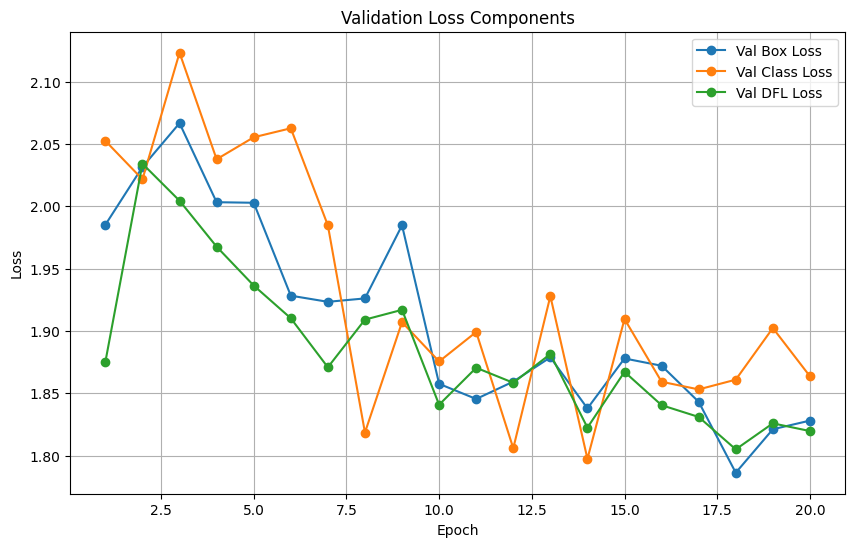

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

results_path = Path('/content/runs/detect/smoke_fire_detection_resumed/results.csv')

try:
    results = pd.read_csv(results_path)
except FileNotFoundError:
    raise FileNotFoundError(f"Файл {results_path} не найден")

print("Доступные столбцы:", results.columns.tolist())

plt.figure(figsize=(10, 6))
plt.plot(results['epoch'], results['val/box_loss'], label='Val Box Loss', marker='o')
plt.plot(results['epoch'], results['val/cls_loss'], label='Val Class Loss', marker='o')
plt.plot(results['epoch'], results['val/dfl_loss'], label='Val DFL Loss', marker='o')

plt.title('Validation Loss Components')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
best_pt_path = '/content/best (3).pt'
resume_args = {
    'model': best_pt_path,
    'data': 'data.yaml',
    'epochs': 40,
    'batch': 8,
    'imgsz': 640,
    'optimizer': 'AdamW',
    'lr0': 0.0001,
    'lrf': 0.01,
    'patience': 10,
    'conf': 0.15,
    'iou': 0.45,
    'hsv_h': 0.01,
    'mosaic': 0.5,
    'mixup': 0.05,
    'fliplr': 0.3,
    'degrees': 10.0,
    'weight_decay': 0.001,
    'device': 0,
    'name': 'smoke_fire_detection_tuned'
}

In [ ]:
resume_args['weight_decay'] = 0.0001
resume_args['hsv_h'] = 0.01
resume_args['degrees'] = 10.0
resume_args['mixup'] = 0.0
resume_args['copy_paste'] = 0.0
resume_args['cos_lr'] = True

In [ ]:
model = YOLO(resume_args['model'])
model.train(**resume_args)

Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/best (3).pt, data=data.yaml, epochs=40, time=None, patience=10, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=smoke_fire_detection_tuned3, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=0.15, iou=0.45, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, 

train: Scanning /content/475_fire_train/labels.cache... 1142 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1142/1142 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/474_fire_val/labels.cache... 308 images, 0 backgrounds, 0 corrupt: 100%|██████████| 308/308 [00:00<?, ?it/s]


Plotting labels to runs/detect/smoke_fire_detection_tuned3/labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0001), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/smoke_fire_detection_tuned3
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      4.94G      1.463      1.336      1.532         56        640: 100%|██████████| 143/143 [00:43<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:06<00:00,  3.14it/s]

                   all        308       1285      0.537      0.427      0.492       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      5.71G      1.412      1.259      1.511         26        640: 100%|██████████| 143/143 [00:42<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.02it/s]

                   all        308       1285      0.584      0.459      0.539        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      5.71G      1.375      1.202      1.472         29        640: 100%|██████████| 143/143 [00:42<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:06<00:00,  3.14it/s]

                   all        308       1285       0.57      0.492      0.561      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      5.71G      1.382      1.205      1.479         44        640: 100%|██████████| 143/143 [00:41<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:06<00:00,  3.20it/s]

                   all        308       1285      0.628       0.44      0.547      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      5.71G      1.354      1.166      1.465         21        640: 100%|██████████| 143/143 [00:41<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:04<00:00,  4.00it/s]

                   all        308       1285       0.61      0.458      0.548      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      5.71G       1.34       1.15      1.458         35        640: 100%|██████████| 143/143 [00:41<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:06<00:00,  3.19it/s]

                   all        308       1285      0.605      0.451      0.545      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      5.71G      1.331      1.119      1.454         22        640: 100%|██████████| 143/143 [00:41<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.97it/s]

                   all        308       1285      0.601      0.465      0.555      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      5.71G      1.331      1.117      1.438         33        640: 100%|██████████| 143/143 [00:41<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.92it/s]

                   all        308       1285       0.63      0.429       0.53      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      5.71G      1.317      1.116      1.447         31        640: 100%|██████████| 143/143 [00:41<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.41it/s]

                   all        308       1285      0.599      0.454      0.542      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      5.72G      1.321      1.095      1.439         20        640: 100%|██████████| 143/143 [00:41<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:06<00:00,  3.28it/s]

                   all        308       1285      0.608      0.442      0.535      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      5.79G      1.323      1.092      1.435         43        640: 100%|██████████| 143/143 [00:41<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.97it/s]

                   all        308       1285      0.586      0.475      0.559      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      5.85G      1.305      1.074      1.423         29        640: 100%|██████████| 143/143 [00:41<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:04<00:00,  4.03it/s]

                   all        308       1285       0.64      0.428       0.53      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      5.85G      1.279      1.061      1.414         42        640: 100%|██████████| 143/143 [00:41<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:06<00:00,  3.21it/s]

                   all        308       1285      0.612      0.453      0.548      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      5.86G      1.292      1.041       1.41         35        640: 100%|██████████| 143/143 [00:41<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.80it/s]

                   all        308       1285      0.598      0.461      0.539      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      5.92G      1.263       1.03      1.404         27        640: 100%|██████████| 143/143 [00:41<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:04<00:00,  4.01it/s]

                   all        308       1285      0.644      0.429      0.542      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      5.98G      1.269      1.013      1.387         28        640: 100%|██████████| 143/143 [00:41<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:06<00:00,  3.24it/s]

                   all        308       1285      0.639      0.436      0.546      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      5.98G       1.25      1.008      1.393         28        640: 100%|██████████| 143/143 [00:41<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:06<00:00,  3.30it/s]

                   all        308       1285       0.55      0.472      0.538        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      5.98G      1.237     0.9959      1.374         18        640: 100%|██████████| 143/143 [00:41<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:04<00:00,  4.08it/s]

                   all        308       1285      0.615      0.437      0.536      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      6.06G      1.241     0.9857      1.378         36        640: 100%|██████████| 143/143 [00:41<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.50it/s]

                   all        308       1285      0.648      0.414       0.53        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      6.12G      1.235     0.9663      1.381         25        640: 100%|██████████| 143/143 [00:41<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.87it/s]

                   all        308       1285       0.62      0.425      0.531      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      6.12G      1.237     0.9737      1.381         32        640: 100%|██████████| 143/143 [00:41<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.35it/s]

                   all        308       1285      0.545      0.453      0.528      0.295
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 11, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



21 epochs completed in 0.303 hours.
Optimizer stripped from runs/detect/smoke_fire_detection_tuned3/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/smoke_fire_detection_tuned3/weights/best.pt, 52.0MB

Validating runs/detect/smoke_fire_detection_tuned3/weights/best.pt...
Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,918 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:08<00:00,  2.45it/s]


                   all        308       1285      0.587      0.477      0.559      0.317
                  fire        303        761      0.566      0.585      0.615      0.358
                 smoke        250        524      0.607      0.368      0.504      0.276
Speed: 0.3ms preprocess, 7.8ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/detect/smoke_fire_detection_tuned3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c0f372d0c10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [ ]:
val_results = model.val()

print("\nИтоговые метрики валидации:")
print(f"Общий mAP50: {val_results.box.map50:.4f}")
print(f"Общий mAP50-95: {val_results.box.map:.4f}\n")

print("Метрики для fire:")
print(f"Precision: {val_results.box.p[0]:.4f}")  # fire precision
print(f"Recall: {val_results.box.r[0]:.4f}")     # fire recall

print("\nМетрики для smoke:")
print(f"Precision: {val_results.box.p[1]:.4f}")  # smoke precision
print(f"Recall: {val_results.box.r[1]:.4f}")     # smoke recall

Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,918 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /content/474_fire_val/labels.cache... 308 images, 0 backgrounds, 0 corrupt: 100%|██████████| 308/308 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:08<00:00,  4.74it/s]


                   all        308       1285      0.587      0.475       0.56      0.318
                  fire        303        761      0.568      0.582      0.616      0.359
                 smoke        250        524      0.607      0.368      0.505      0.277
Speed: 0.7ms preprocess, 17.4ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/smoke_fire_detection_tuned32

Итоговые метрики валидации:
Общий mAP50: 0.5603
Общий mAP50-95: 0.3182

Метрики для fire:
Precision: 0.5679
Recall: 0.5821

Метрики для smoke:
Precision: 0.6069
Recall: 0.3683


Последний этап дообучения ухудшил качество модели, поэтому оставим в качестве финального варианта модель, полученную одним шагом ранее.

Доступные столбцы: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


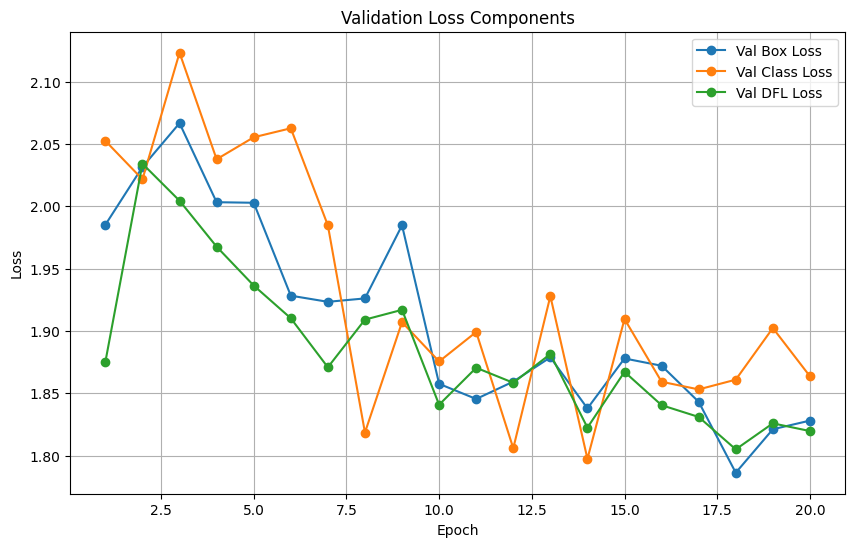

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

results_path = Path('/content/runs/detect/smoke_fire_detection_resumed/results.csv')

try:
    results = pd.read_csv(results_path)
except FileNotFoundError:
    raise FileNotFoundError(f"Файл {results_path} не найден. Проверьте путь!")

print("Доступные столбцы:", results.columns.tolist())

plt.figure(figsize=(10, 6))
plt.plot(results['epoch'], results['val/box_loss'], label='Val Box Loss', marker='o')
plt.plot(results['epoch'], results['val/cls_loss'], label='Val Class Loss', marker='o')
plt.plot(results['epoch'], results['val/dfl_loss'], label='Val DFL Loss', marker='o')

plt.title('Validation Loss Components')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Из графика видно, что компонента Val Class Loss перестала уменьшаться на ряду с другими компонентами. Возможно, это говорит о том, что модель начала переобучаться и вышла на плато по своим результатам. Поэтому дальнейшее обучение решено прекратить.

# Оценка скорости работы модели

Для приближённой оценки скорости возьмём произвольные N = 10 изображений из валидационного датасета и усредним время работы модели на них.

In [ ]:
import time
import glob

model = YOLO('/content/best (3).pt')

img_dir = '474_fire_val/images'
img_paths = glob.glob(os.path.join(img_dir, '*.jpg'))[:10]

_ = model.predict(img_paths[0], imgsz=640)

start_time = time.time()

for img_path in img_paths:
    _ = model.predict(img_path, imgsz=640, verbose=False)

total_time = time.time() - start_time
avg_time_per_image = total_time / len(img_paths)
fps = 1 / avg_time_per_image

print(f"Среднее время обработки: {avg_time_per_image:.4f} сек")
print(f"FPS: {fps:.2f} (кадров в секунду)")


image 1/1 /content/474_fire_val/images/pic(158).jpg: 352x640 1 fire, 65.4ms
Speed: 19.3ms preprocess, 65.4ms inference, 405.6ms postprocess per image at shape (1, 3, 352, 640)
Среднее время обработки: 0.0420 сек
FPS: 23.82 (кадров в секунду)


In [ ]:
import matplotlib.pyplot as plt

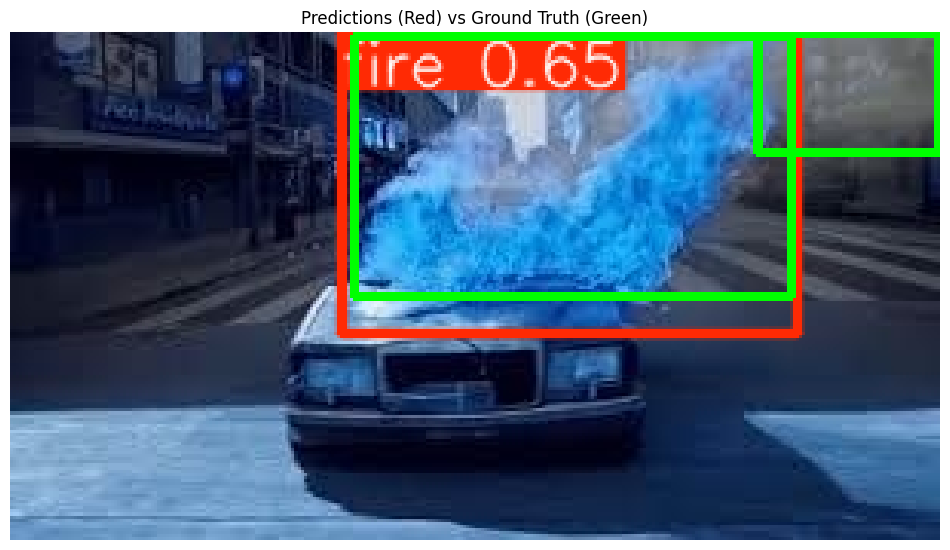

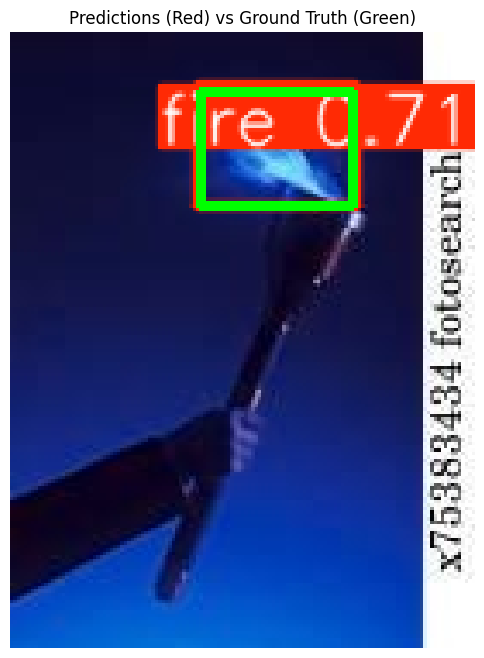

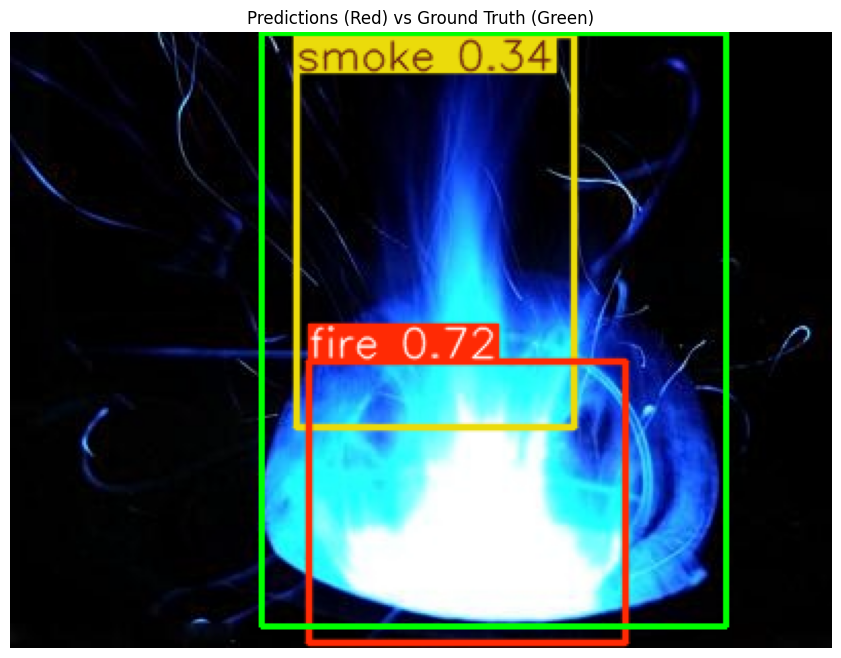

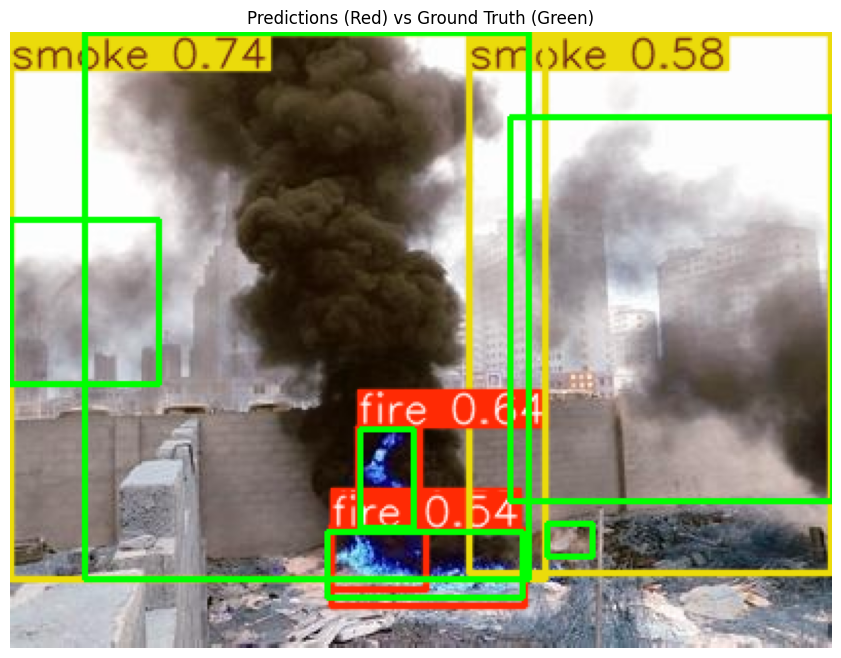

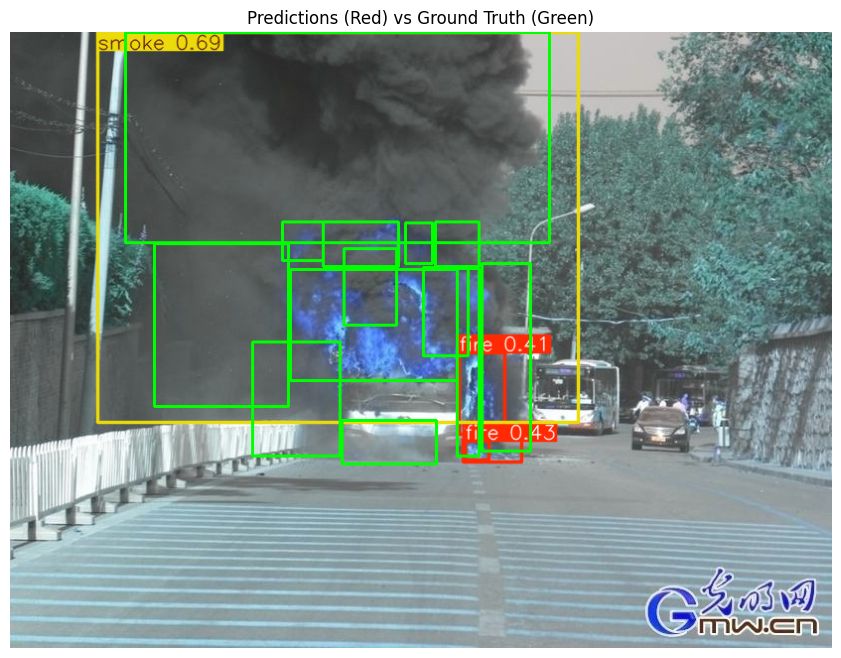

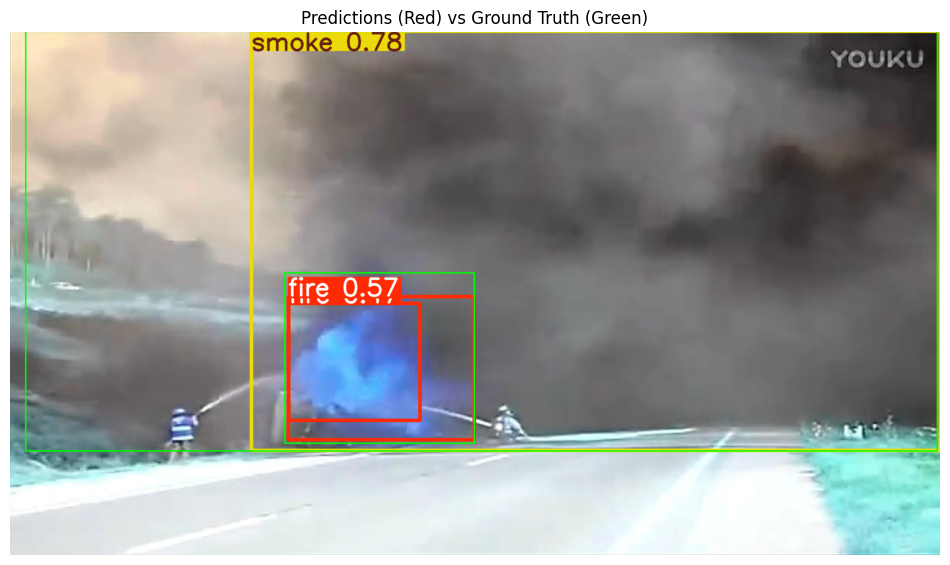

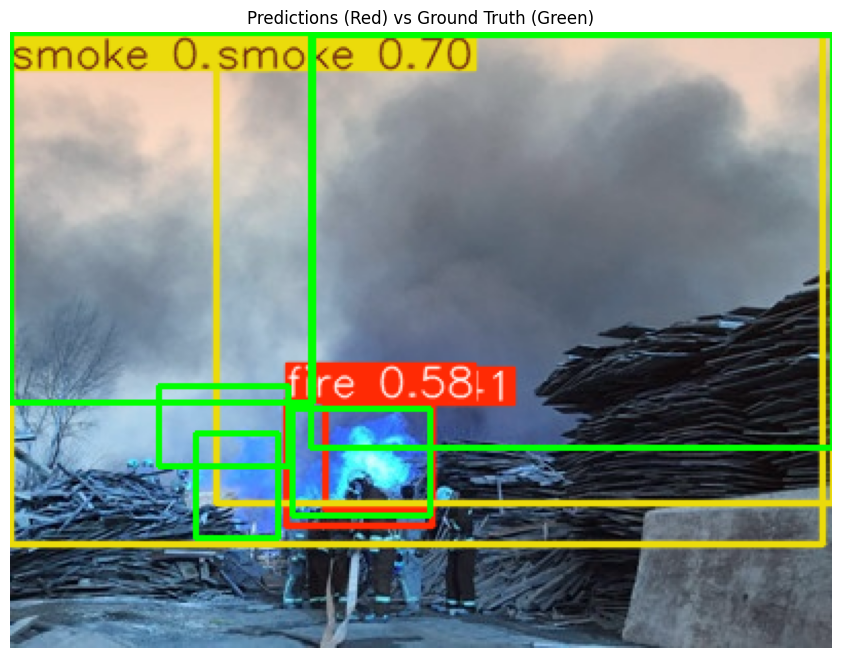

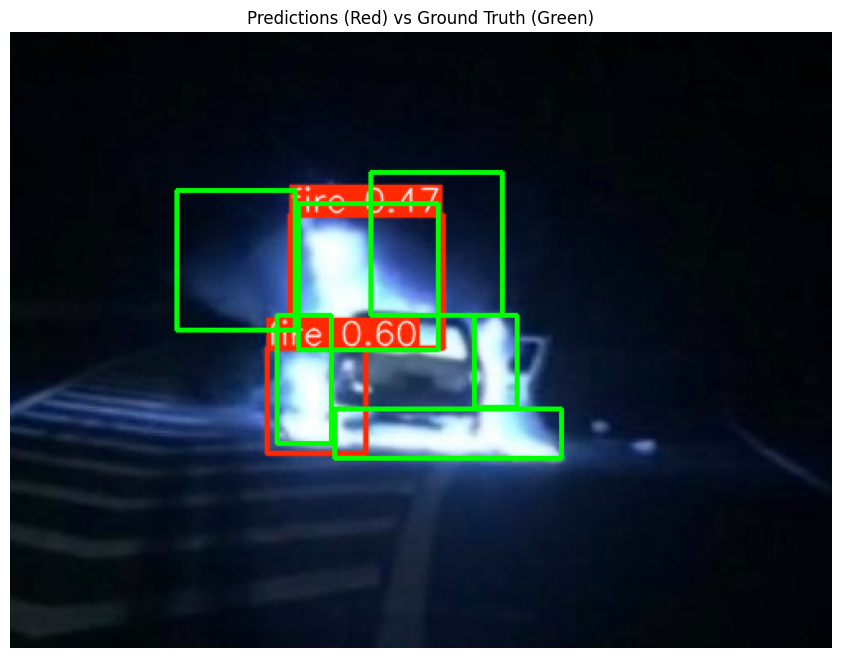

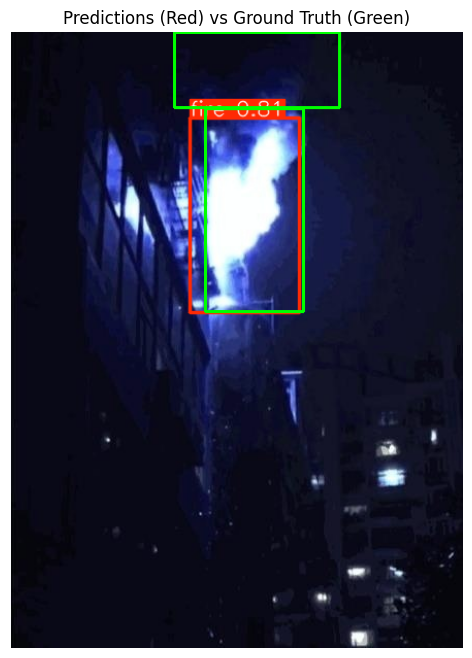

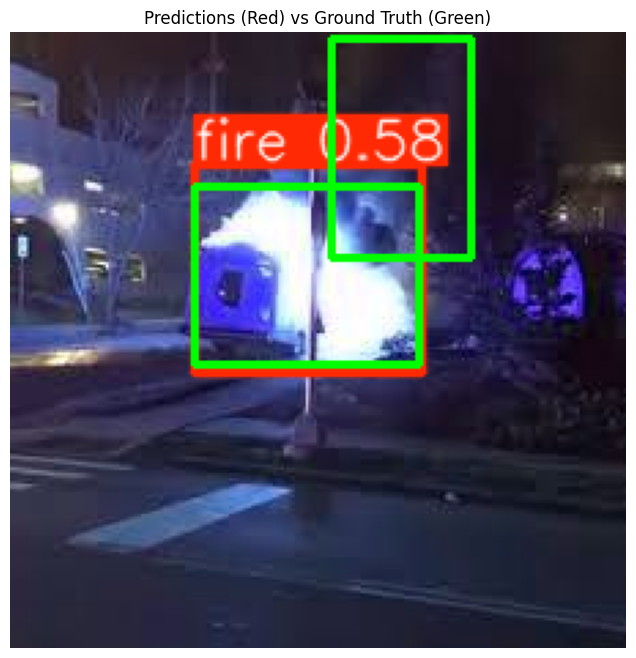

In [ ]:
def plot_predictions_vs_gt(img_path, model, labels_dir='474_fire_val/labels', conf=0.3):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    results = model.predict(img_path, imgsz=640, conf=conf)
    pred_img = results[0].plot()

    label_path = os.path.join(labels_dir, os.path.basename(img_path).replace('.jpg', '.txt'))

    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            lines = f.readlines()

        h, w = img.shape[:2]
        for line in lines:
            class_id, x_center, y_center, width, height = map(float, line.strip().split())
            x1 = int((x_center - width/2) * w)
            y1 = int((y_center - height/2) * h)
            x2 = int((x_center + width/2) * w)
            y2 = int((y_center + height/2) * h)

            cv2.rectangle(pred_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    plt.figure(figsize=(12, 8))
    plt.imshow(pred_img)
    plt.axis('off')
    plt.title('Predictions (Red) vs Ground Truth (Green)')
    plt.show()

for img_path in img_paths[:10]:
    plot_predictions_vs_gt(img_path, model)

# Демонстрация результатов работы модели

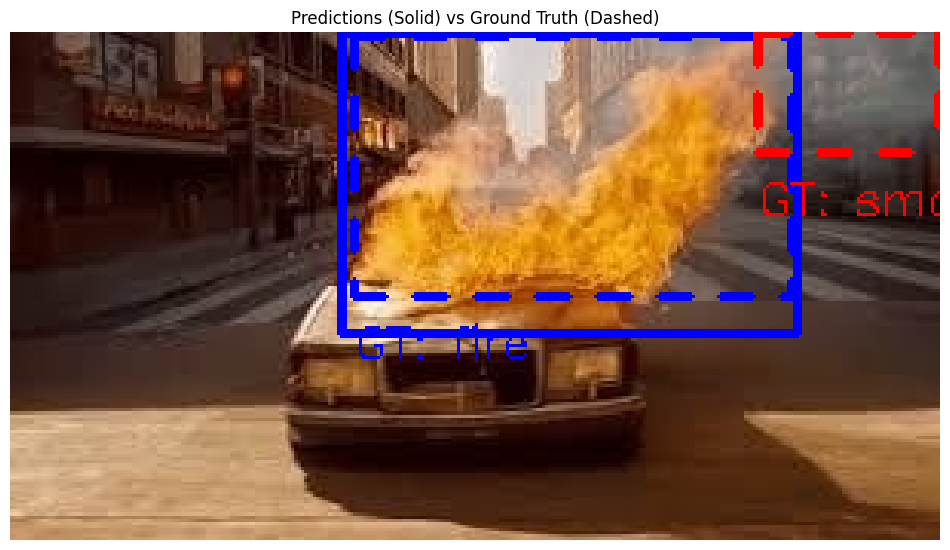

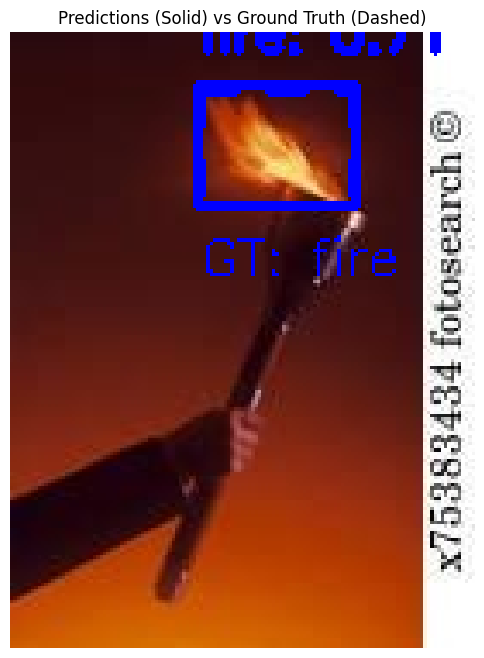

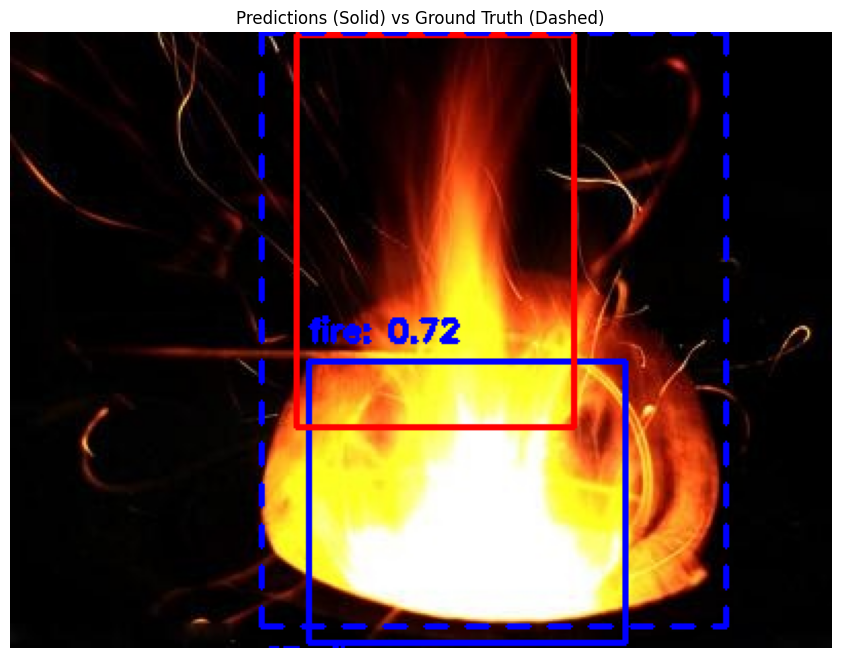

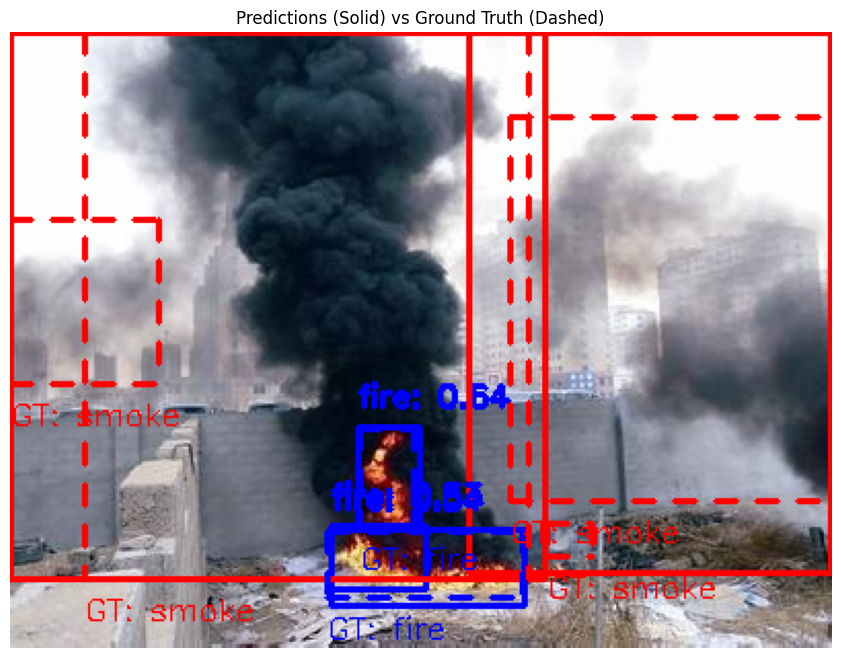

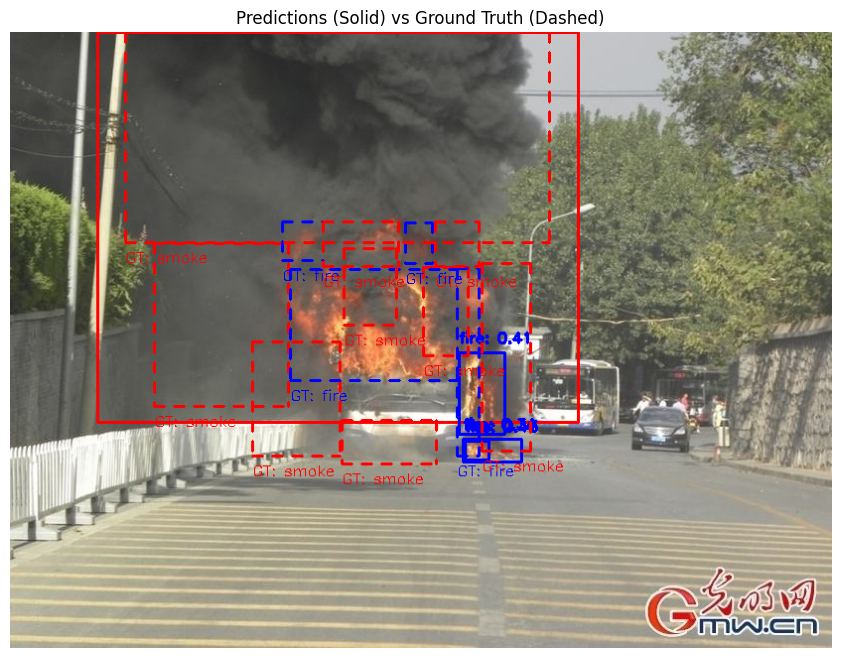

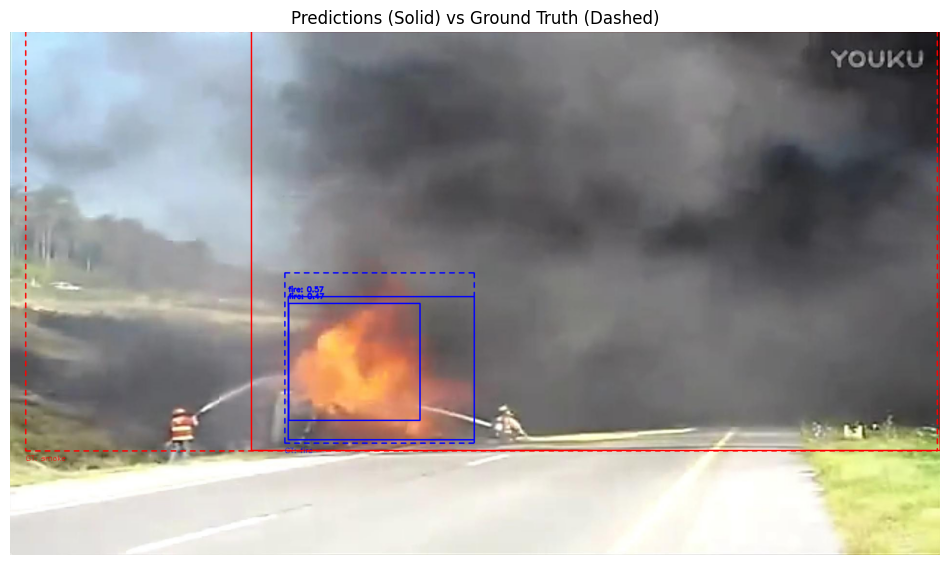

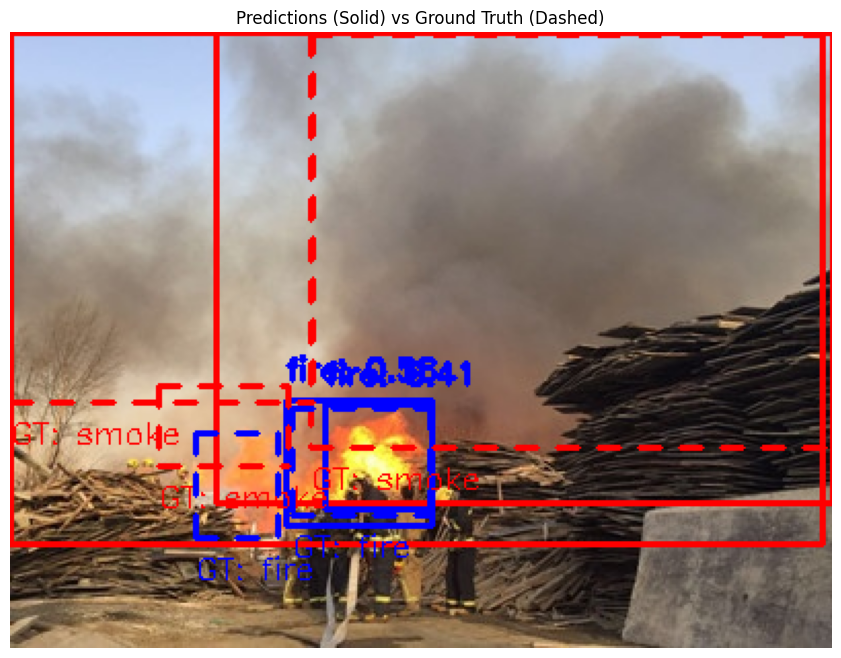

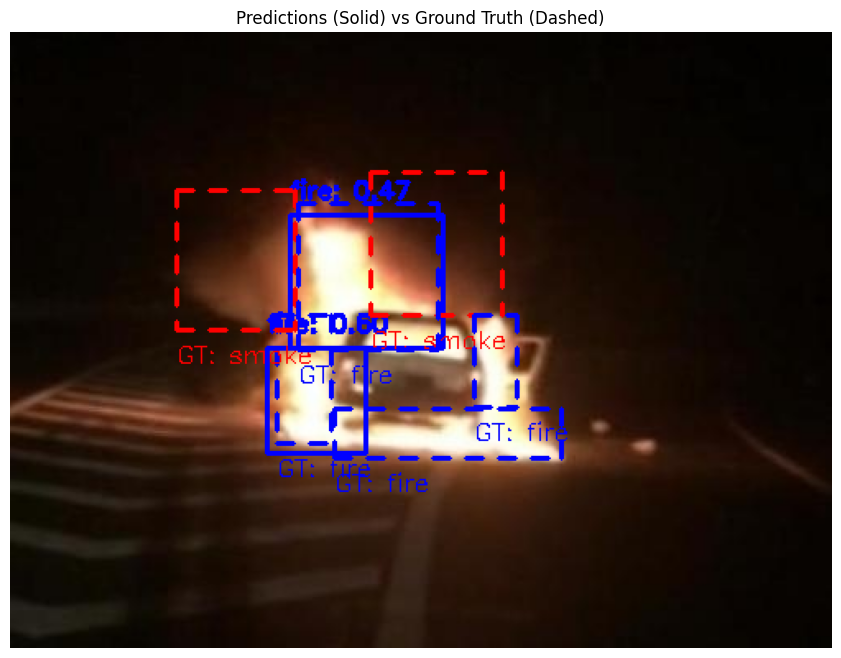

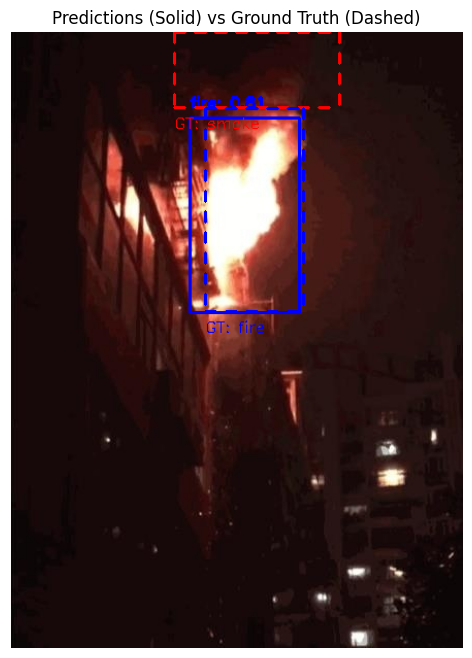

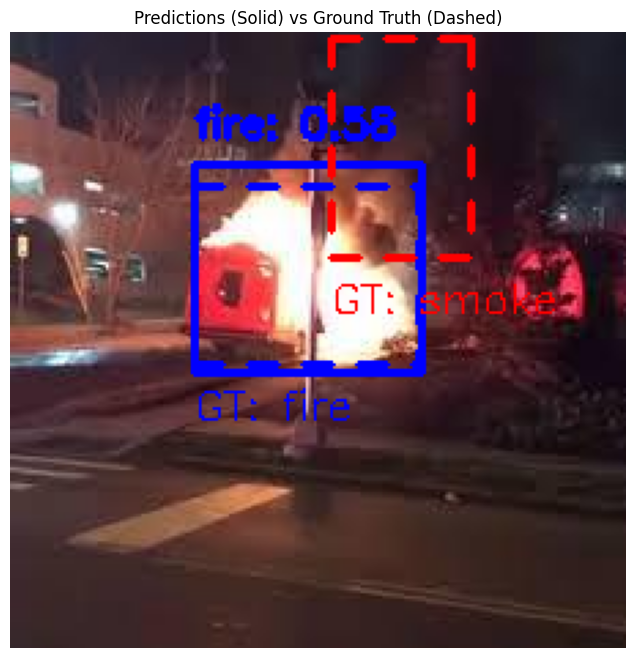

In [ ]:
def plot_predictions_vs_gt(img_path, model, labels_dir='474_fire_val/labels', conf=0.3):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    class_colors = {
        0: (0, 0, 255),    # Красный для fire (класс 0)
        1: (255, 0, 0)      # Синий для smoke (класс 1)
    }

    results = model.predict(img_path, imgsz=640, conf=conf)

    vis_img = img.copy()

    for box in results[0].boxes:
        class_id = int(box.cls)
        conf = float(box.conf)
        x1, y1, x2, y2 = map(int, box.xyxy[0])

        color = class_colors.get(class_id, (0, 255, 0))
        cv2.rectangle(vis_img, (x1, y1), (x2, y2), color, 2)

        label = f"{results[0].names[class_id]}: {conf:.2f}"
        cv2.putText(vis_img, label, (x1, y1 - 10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    label_path = os.path.join(labels_dir, os.path.basename(img_path).replace('.jpg', '.txt'))

    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            lines = f.readlines()

        h, w = img.shape[:2]
        for line in lines:
            parts = line.strip().split()
            if len(parts) != 5:
                continue

            class_id, x_center, y_center, width, height = map(float, parts)
            class_id = int(class_id)

            x1 = int((x_center - width/2) * w)
            y1 = int((y_center - height/2) * h)
            x2 = int((x_center + width/2) * w)
            y2 = int((y_center + height/2) * h)

            color = class_colors.get(class_id, (0, 255, 0))

            draw_dashed_rectangle(vis_img, (x1, y1), (x2, y2), color, 2, dash_length=10)

            class_name = "fire" if class_id == 0 else "smoke" if class_id == 1 else str(class_id)
            cv2.putText(vis_img, f"GT: {class_name}", (x1, y2 + 20),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    plt.figure(figsize=(12, 8))
    plt.imshow(vis_img)
    plt.axis('off')
    plt.title('Predictions (Solid) vs Ground Truth (Dashed)')
    plt.show()

def draw_dashed_rectangle(img, pt1, pt2, color, thickness=1, dash_length=10):
    x1, y1 = pt1
    x2, y2 = pt2

    for x in range(x1, x2, dash_length * 2):
        end_x = min(x + dash_length, x2)
        cv2.line(img, (x, y1), (end_x, y1), color, thickness)
        cv2.line(img, (x, y2), (end_x, y2), color, thickness)

    for y in range(y1, y2, dash_length * 2):
        end_y = min(y + dash_length, y2)
        cv2.line(img, (x1, y), (x1, end_y), color, thickness)
        cv2.line(img, (x2, y), (x2, end_y), color, thickness)

for img_path in img_paths[:10]:
    plot_predictions_vs_gt(img_path, model)

Сделаем визуальную оценку. Модель научилась неплохо и точно детектировать огонь, однако с дымом качество детекции хуже. В некоторых случаях модель не замечает слабый, размытый дым.


# Итоги

Поскольку при выполнении данной задачи я был ограничен в вычислительных единицах, что делало трудным использовать продвинутые, вычислительно затратные подходы, мне не удалось получить препочтительные значения по метрикам. В итоге получены следующие результаты:

Метрики для fire:
- mAP50: 0.616
- precision: 0.5811
- recall: 0.5760

Метрики для smoke:
- mAP50 = 0.505
- precision = 0.6548
- recall 0.3621

На мой взгляд, результаты можно улучшить несколькими способами или их комбинацией:

- использовать больший масштаб изображения, например 1024 при наличии вычислительных ресурсов. Это позволит модели лучше научиться различать небольшие очаги огня и дыма.
- попытаться добавить в датасет больше сложных примеров, таких как полупрозрачный дым и мелкое пламя
- использовать более продвинутые модификации YOLO, такие как YOLOFM на базе YOLOv5n или YOLOv5s с модулем CoT и Self - attention

Модель демонстрирует приемлемые результаты для детекции огня, но требует доработки для улучшения детекции дыма. Оптимизация гиперпараметров и расширение датасета могут повысить качество модели. Результаты показывают, что модель готова к тестированию в реальных условиях, но требует дальнейшего улучшения для увеличения точности.